# Definiëren van hulpfuncties


Importeer libraries:

In [2]:
import numpy as np
from tqdm import tqdm
from numpy import sin, cos
import scipy
from math import log
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time as clock
import asyncio
from matplotlib import animation
from IPython.display import Video
import time as system_time
import seaborn as sns
import os
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.ticker import StrMethodFormatter
import locale

Definieer de constanten / configuratie:

In [3]:
G = 9.81
sns.set_theme()
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")
plt.rcParams['axes.formatter.use_locale'] = True

Definieer de afgeleiden als een stelsel van 4 differentiaalvergelijkingen van de eerste order:

In [4]:
def derivs(state, t, m1, m2, l1, l2):   
    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (m1 + m2) * l1 - m2 * l1 * cos(delta) * cos(delta)
    dydx[1] = ((m2 * l1 * state[1] * state[1] * sin(delta) * cos(delta)
                + m2 * G * sin(state[2]) * cos(delta)
                + m2 * l2 * state[3] * state[3] * sin(delta)
                - (m1 + m2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (l2 / l1) * den1
    dydx[3] = ((- m2 * l2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (m1 + m2) * G * sin(state[0]) * cos(delta)
                - (m1 + m2) * l1 * state[1] * state[1] * sin(delta)
                - (m1 + m2) * G * sin(state[2]))
               / den2)
    
    return dydx

Definieer een functie voor het genereren van data vanuit de initiële waarden:

In [5]:
def get_resulting_array(t, theta1, theta1_dot, theta2, theta2_dot, m1, m2, l1, l2):
    state = [theta1, theta1_dot, theta2, theta2_dot]
    
    results = scipy.integrate.odeint(lambda S, t : derivs(S, t, m1, m2, l1, l2), state, t)
    return results

Definieer een functie voor het omzetten van data naar cartesische coördinaten:

In [6]:
def get_coordinates(results, l1, l2):
    theta1 = results[:,0]
    theta2 = results[:,2]
    
    return (
        l1*np.sin(theta1),
        -l1*np.cos(theta1),
        l1*np.sin(theta1) + l2*np.sin(theta2),
        -l1*np.cos(theta1) - l2*np.cos(theta2)
    )

Definieer en functie voor de afstanden tussen twee slingers:

In [7]:
def get_differences(results1, results2):
    return np.abs(np.subtract(results1, results2))

Definieer een functie om de Lyapunov exponenten te berekenen uit twee resultaten:

In [8]:
def get_lyapunov_values(t, differences):
    thetha1_differences = differences[:, 0]
    lyapunov = [0]
    
    for index, time in enumerate(t):
        if (index == 0):
            continue
        exponent = (1 / time) * log(thetha1_differences[index] / thetha1_differences[0])
        lyapunov.append(exponent)
        
    return lyapunov

Maak een class om te helpen bij het loggen van laadtijden:

In [9]:
class TimeLogger:
    def __init__(self, total_frames, name):
        self.total_frames = total_frames
        self.name = name
        self.current_frame = 0
        self.last_result = 0
        self.gain = 0.1
        self.start_time = system_time.time()
        
    def update(self):
        self.current_frame += 1
        
        now = system_time.time()
        dt = now - self.start_time
        self.start_time = now
        
        if (self.last_result == 0):
            self.last_result = dt
                
        filtered_dt = self.gain * dt + (1 - self.gain) * self.last_result
        self.last_result = filtered_dt
            
        frames_remaining = self.total_frames - self.current_frame
        time_remaining = frames_remaining * filtered_dt
        time_remaining_formatted = clock.strftime("%H:%M:%S", clock.gmtime(time_remaining))
        print(str(self.name) + " completion: " + (str(round(self.current_frame / self.total_frames * 1000) / 10)) + "%, time remaining: " + str(time_remaining_formatted), end='\r')

Class voor slinger tekenen:

In [10]:
class Pendulum:
    def __init__(self, ax, coordinates, pendulum_dist, color, zorder):
        self.coordinates = coordinates
        self.pendulum_dist = pendulum_dist
        self.pendulum_line, = ax.plot([], [], color=color, zorder=zorder)
        self.pendlum_point = ax.scatter([], [], color=color, zorder=zorder)
        
    def update(self, frame):
        x1, y1, x2, y2 = self.coordinates
        
        self.pendulum_line.set_data([0 + self.pendulum_dist, x1[frame] + self.pendulum_dist, x2[frame] + self.pendulum_dist], [0, y1[frame], y2[frame]])
        self.pendlum_point.set_offsets([[x1[frame] + self.pendulum_dist, y1[frame]], [x2[frame] + self.pendulum_dist, y2[frame]]])

# Animaties

Een slinger:

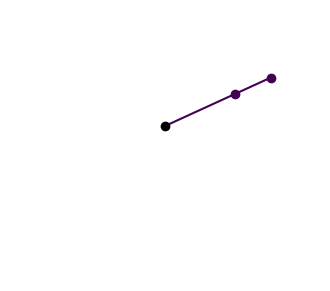

In [11]:
# Animatie configuratie
t_end = 30
FPS = 60
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/one_pendulum.mp4"

sns.reset_orig()

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 2
N = 1
dtheta = 0.001

pendulum_dist = 0

fig, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))

colormap = plt.cm.viridis #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, N)]

coordinates = get_coordinates(get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2), l1, l2)
Ncoordinates = len(coordinates)
pendulum = Pendulum(axs, coordinates, pendulum_dist, colors[0], 0)

pivot_point = axs.scatter([0], [0], color="black", zorder=N+2)
timeLogger = TimeLogger(len(t), "Frame animation")
def animate(frame):
    pivot_point.set_offsets([[0, 0]])
    pendulum.update(frame)
    timeLogger.update()

axs.set_ylim([-4, 3])
axs.set_xlim([-4, 4])
axs.axis('off')
axs.set_aspect('equal')
    
# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name, dpi=1000, savefig_kwargs={"transparent": True})
Video(save_name)

Twee slingers zelfde gestart:


In [55]:
# Animatie configuratie
t_end = 30
FPS = 60
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/two_pendulae_same.mp4"

sns.reset_orig()

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 2
N = 1
theta_range = 1e-2

pendulum_dist = 8

fig, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))

colormap = plt.cm.viridis #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, N)]

coordinates = get_coordinates(get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2), l1, l2)
pendulum1 = Pendulum(axs, coordinates, 0, colors[0], 0)
pendulum2 = Pendulum(axs, coordinates, pendulum_dist, colors[0], 0)

pivot_point = axs.scatter([0, pendulum_dist], [0, 0], color="black", zorder=N+2)
timeLogger = TimeLogger(len(t), "Frame animation")
def animate(frame):
    pendulum1.update(frame)
    pendulum2.update(frame)
    timeLogger.update()

axs.set_ylim([-4, 3])
axs.set_xlim([-4, 4 + pendulum_dist])
axs.axis('off')
axs.set_aspect('equal')
    
# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name, dpi=1000)
Video(save_name)

Twee slingers andere start:

In [56]:
# Animatie configuratie
t_end = 30
FPS = 60
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/two_pendulae_different.mp4"

sns.reset_orig()

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 2
N = 1
dtheta = 0.001
pendulum_dist = 8

fig, axs = plt.subplots(1, 1, figsize=(4, 4), gridspec_kw=dict(width_ratios=[4]))

colormap = plt.cm.viridis #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, N)]

coordinates1 = get_coordinates(get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2), l1, l2)
coordinates2 = get_coordinates(get_resulting_array(t, theta1 + dtheta, 0, theta2 + dtheta, 0, m1, m2, l1, l2), l1, l2)
pendulum1 = Pendulum(axs, coordinates1, 0, colors[0], 0)
pendulum2 = Pendulum(axs, coordinates2, pendulum_dist, colors[0], 0)

pivot_point = axs.scatter([0, pendulum_dist], [0, 0], color="black", zorder=N+2)
timeLogger = TimeLogger(len(t), "Frame animation")
def animate(frame):
    pendulum1.update(frame)
    pendulum2.update(frame)
    timeLogger.update()

axs.set_ylim([-4, 3])
axs.set_xlim([-4, 4 + pendulum_dist])
axs.axis('off')
axs.set_aspect('equal')
    
# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name, dpi=1000)
Video(save_name)

Regressie meerdere slingers:

In [63]:
# Animatie configuratie
t_end = 20
FPS = 30
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/pemdulum_many.mp4"

sns.reset_orig()

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 2
N = 10000
theta_range = 1e-2

pendulae = []
fig = plt.figure()

colormap = plt.cm.viridis #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, N)]


for i in range(N):
    coordinates = get_coordinates(get_resulting_array(t, theta1 + theta_range / N * i, 0, theta2 + theta_range / N * i, 0, m1, m2, l1, l2), l1, l2)
    
    pendulae.append(Pendulum(plt, coordinates, colors[i], i))
    

pivot_point = plt.scatter([0], [0], color="black", zorder=N+2)
timeLogger = TimeLogger(len(t), "Frame animation")
def animate(frame):
    pivot_point.set_offsets([[0, 0]])
    
    for i in range(N):
        pendulae[i].update(frame)
    
    timeLogger.update()


plt.ylim([-4, 3])
plt.xlim([-4, 4])
plt.axis('off')
# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name)
Video(save_name)